# Phase 3: Statistical Models (ARIMA / SARIMA / SARIMAX)

Parameter selection via AIC/BIC, residual diagnostics, and exogenous variables.

In [1]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.data_loader import REPO_ROOT, load_and_merge_data, get_aggregated_series
from src.models.statistical import (
    fit_sarima,
    fit_sarimax,
    grid_search_sarima,
    residual_diagnostics,
    forecast_sarima,
)
from src.metrics import evaluate_forecasts

## 1. Load Data & Split

In [2]:
data_dir = REPO_ROOT / "data" / "store-sales-time-series-forecasting"
df = load_and_merge_data(data_dir)
daily_sales = get_aggregated_series(df)

train_end = '2016-12-31'
val_start = '2017-01-01'
val_end = '2017-02-28'

train = daily_sales.loc[:train_end]
val = daily_sales.loc[val_start:val_end]

# Exog: onpromotion (aggregated) and holiday flag
daily = df.groupby('date').agg({'sales': 'sum', 'onpromotion': 'sum', 'is_holiday': 'first'}).reset_index()
daily = daily.set_index('date')
exog_train = daily.loc[:train_end][['onpromotion', 'is_holiday']].astype(float)
exog_val = daily.loc[val_start:val_end][['onpromotion', 'is_holiday']].astype(float)

## 2. Grid Search (SARIMA)

In [3]:
# Run SARIMA grid search
grid_result = grid_search_sarima(
    train,
    p_range=(0, 2), d_range=(0, 1), q_range=(0, 2),
    P_range=(0, 1), D_range=(0, 1), Q_range=(0, 1),
    s=7,
    metric='aic',
)

/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency inform

## 3. Fit Best SARIMA

In [4]:
# Access best params (grid_result is a dict from grid_search_sarima)
params = grid_result.get('best_params')
best_score = grid_result.get('best_score')

if params is None:
    raise ValueError(
        "Grid search did not find any valid SARIMA model (all combinations failed). "
        "Try widening p_range/q_range or using a smaller seasonal order."
    )

# Determine order and seasonal_order
if 'order' in params and 'seasonal_order' in params:
    order = params['order']
    seasonal_order = params['seasonal_order']
else:
    order = (params['p'], params['d'], params['q'])
    seasonal_order = (params['P'], params['D'], params['Q'], params['s'])

# Fit SARIMA
_, sarima_result = fit_sarima(train, order, seasonal_order)

# Print summary
print(sarima_result.summary())

# Best params and score
print('Best params:', params)
print('Best AIC:', best_score)


/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1457
Model:             SARIMAX(1, 0, 2)x(0, 1, [1], 7)   Log Likelihood              -18614.423
Date:                             Mon, 16 Feb 2026   AIC                          37238.847
Time:                                     17:22:13   BIC                          37265.243
Sample:                                          0   HQIC                         37248.697
                                            - 1457                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8616      0.033     25.771      0.000       0.796       0.927
ma.L1         -0.2872      

## 4. Residual Diagnostics

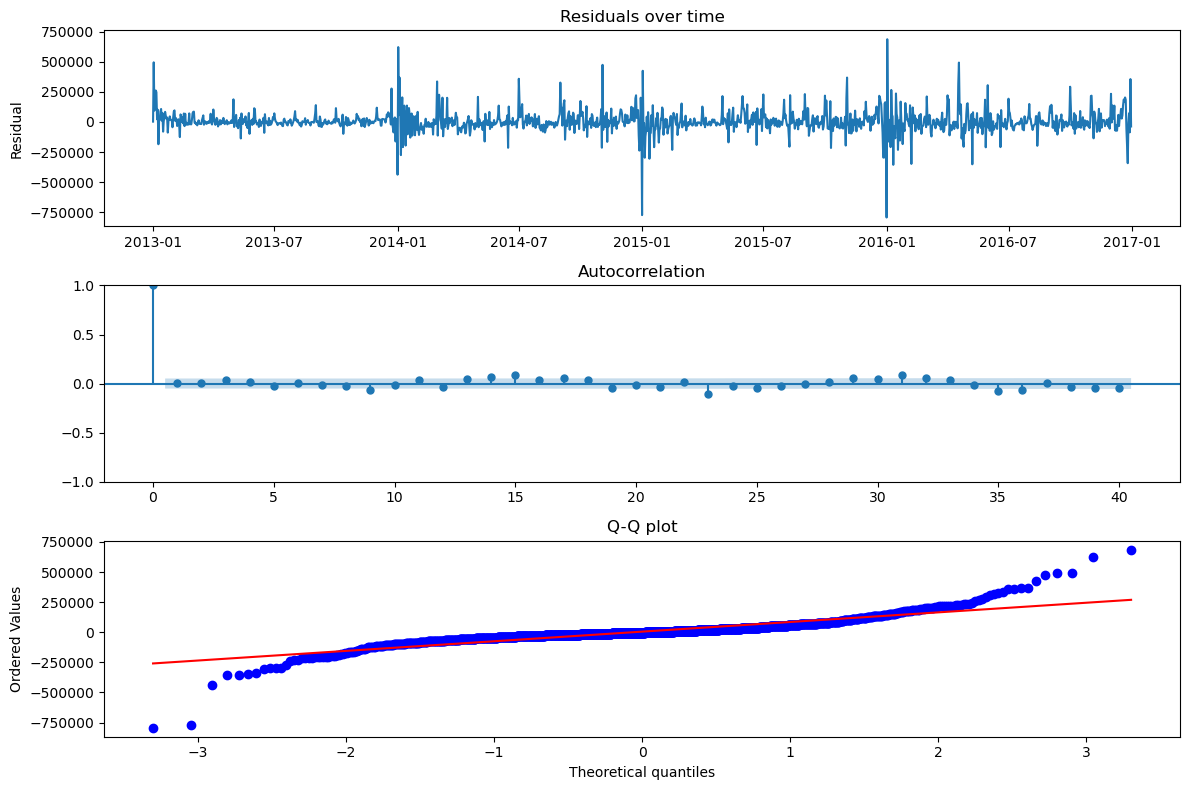

In [5]:
residual_diagnostics(sarima_result)
plt.show()

## 5. SARIMAX (with promotions & holiday)

In [6]:
try:
    _, sarimax_result = fit_sarimax(train, exog_train, order, seasonal_order)
    y_sarimax = forecast_sarima(sarimax_result, len(val), exog_val)
except Exception as e:
    print(f'SARIMAX failed: {e}')
    y_sarimax = None

/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model wit

## 6. Forecast & Metrics

SARIMA: {'MAE': 191170.88477752186, 'RMSE': 257069.8100760998, 'MAPE': 183.15850371397295}
SARIMAX: {'MAE': 163041.65816421222, 'RMSE': 208438.93218891078, 'MAPE': 150.42310946933696}


/Users/adhvaitpurayil/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


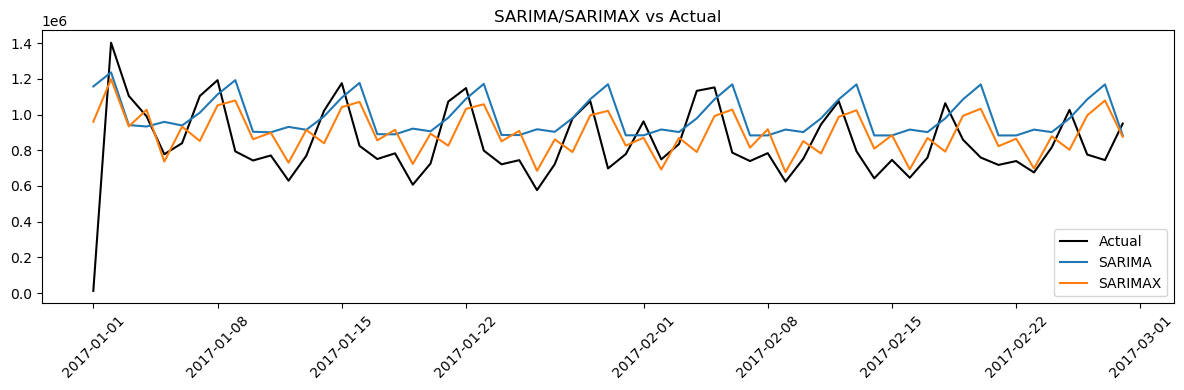

In [7]:
y_true = val.values
y_sarima = forecast_sarima(sarima_result, len(val))

print('SARIMA:', evaluate_forecasts(y_true, y_sarima))
if y_sarimax is not None:
    print('SARIMAX:', evaluate_forecasts(y_true, y_sarimax))

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(val.index, y_true, label='Actual', color='black')
ax.plot(val.index, y_sarima, label='SARIMA')
if y_sarimax is not None:
    ax.plot(val.index, y_sarimax, label='SARIMAX')
ax.legend()
ax.set_title('SARIMA/SARIMAX vs Actual')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()